Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 404 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=cbb3224f577d4ac50ca170f4dbbf5fb45112f417268039c80b04225eb29c1feb
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 59.6 MB/s 
     |████████████████████████████████| 163 kB 73.6 MB/s 
[15375, 26269]
[2, 2]
[9942, 12411, 22553, 17642, 6309, 2655

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    valid_dataset_idxs = [i for i,labels in enumerate(labels) if tag2idx["O"] in labels]
    valid_dataset_sents = [sent for i,sent in enumerate(dataset) if i in valid_dataset_idxs]
    valid_dataset_labels = [labels for i,labels in enumerate(labels) if i in valid_dataset_idxs]

    random_idxs = np.random.choice(len(valid_dataset_sents), number_of_new_sentences, replace=True)
    base_labels = [valid_dataset_labels[i] for i in random_idxs]

    if not all([tag2idx["O"] in labels for labels in base_labels]):
        raise Exception("Sentence without 'O'-tagged token in the dataset!!!")

    base_sequences = [valid_dataset_sents[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-11-06 05:03:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-06 05:03:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-06 05:04:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10560 words (18161 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2872100   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,034,356
Trainable params: 3,034,356
Non-trainab

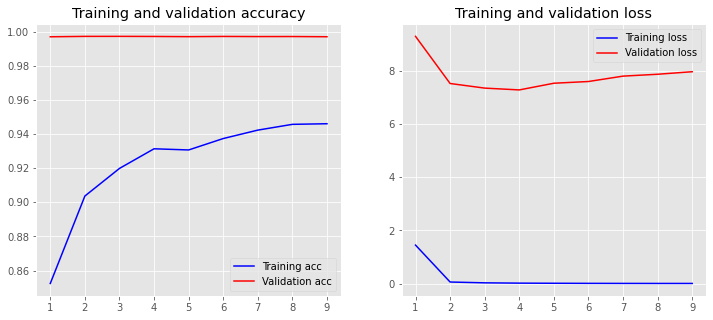

864/864 [==============================] - 66s 73ms/step
F1-score: 76.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.7666447476574059,0.7431280376065652,0.754703240684549,12551.0
test,0.7671875,0.8172436750998668,0.7914248871695679,9012.0
treatment,0.7608328643781654,0.7255554362992379,0.7427755191737173,9317.0
micro avg,0.7651300120713843,0.7594559585492228,0.7622824267442427,30880.0
macro avg,0.7648883706785238,0.7619757163352233,0.7629678823426115,30880.0
weighted avg,0.7650496041210968,0.7594559585492228,0.7618212749075597,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10557 words (18159 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2871600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,033,856
Trainable params: 3,033,856
Non-train

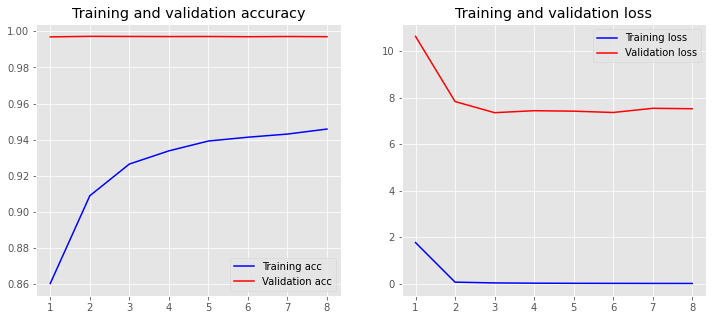

864/864 [==============================] - 67s 74ms/step
F1-score: 77.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7788192731458642,0.7546809019201657,0.7665601100635294,12551.0
test,0.8151837856406733,0.7899467376830892,0.8023668639053254,9012.0
treatment,0.7693743139407245,0.7522807770741655,0.7607315352471916,9317.0
micro avg,0.786535577403766,0.7642487046632125,0.7752319947441899,30880.0
macro avg,0.7877924575757541,0.7656361388924736,0.7765528364053488,30880.0
weighted avg,0.7865821715166198,0.7642487046632125,0.7752513546897744,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10560 words (18153 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2871300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,033,556
Trainable params: 3,033,556
Non-train

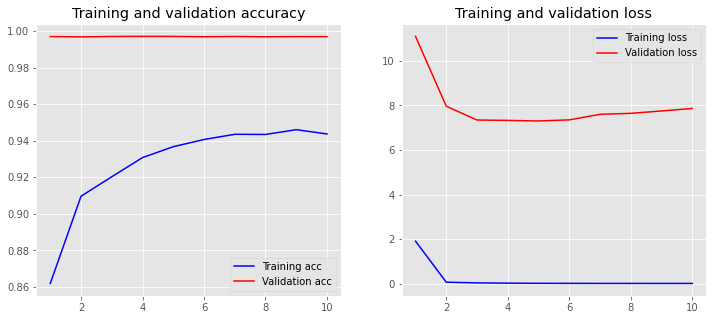

864/864 [==============================] - 70s 77ms/step
F1-score: 75.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.7594435007684219,0.7480678830372082,0.753712771935458,12551.0
test,0.7331001131803684,0.7906125166444741,0.7607709145267204,9012.0
treatment,0.7841070582662245,0.7106364709670495,0.7455661280333316,9317.0
micro avg,0.7578785297778943,0.749190414507772,0.7535094290460216,30880.0
macro avg,0.7588835574050049,0.7497722902162439,0.75334993816517,30880.0
weighted avg,0.7591968607510479,0.749190414507772,0.753314640452179,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10557 words (18157 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2871400   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,033,656
Trainable params: 3,033,656
Non-train

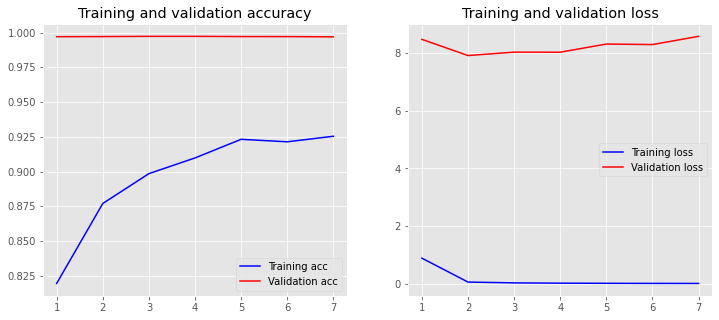

864/864 [==============================] - 68s 75ms/step
F1-score: 77.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7871982504836403,0.7456776352481874,0.7658756137479542,12551.0
test,0.8073765753266273,0.7748557478917,0.7907819489270143,9012.0
treatment,0.7597374650312029,0.7578619727380058,0.758798559991403,9317.0
micro avg,0.7844931617055511,0.7578691709844559,0.7709513769930163,30880.0
macro avg,0.7847707636138236,0.7594651186259643,0.7718187075554571,30880.0
weighted avg,0.7848017130945418,0.7578691709844559,0.7710090004961375,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10573 words (18147 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2872000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,034,256
Trainable params: 3,034,256
Non-train

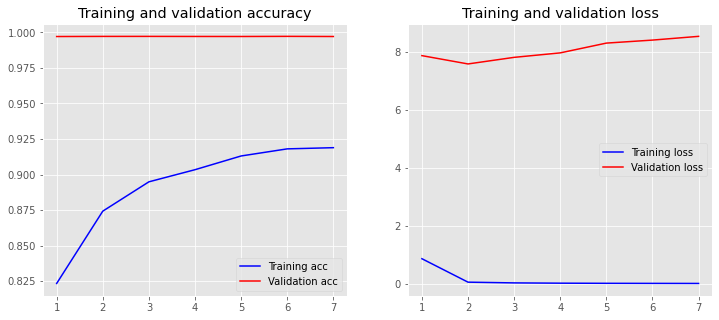

864/864 [==============================] - 67s 75ms/step
F1-score: 77.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7759598783194935,0.7519719544259421,0.7637776159261956,12551.0
test,0.8308348567946374,0.7564358632933866,0.7918917349131672,9012.0
treatment,0.7855674811600822,0.7384351186004079,0.7612724757952974,9317.0
micro avg,0.7943074915882716,0.749190414507772,0.7710895577108955,30880.0
macro avg,0.7974540720914044,0.7489476454399121,0.7723139422115534,30880.0
weighted avg,0.7948733285035532,0.749190414507772,0.771226581266578,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10553 words (18148 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2870100   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,032,356
Trainable params: 3,032,356
Non-train

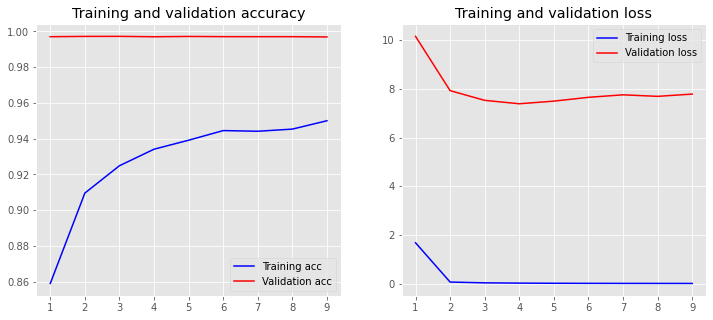

864/864 [==============================] - 70s 77ms/step
F1-score: 75.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7557106071932885,0.7248824794837064,0.7399755998373322,12551.0
test,0.7734879142513398,0.7847314691522415,0.7790691269622694,9012.0
treatment,0.7274049449407853,0.7515294622732639,0.7392704429076703,9317.0
micro avg,0.7521423007011165,0.7503886010362695,0.7512644274413176,30880.0
macro avg,0.7522011554618047,0.7537144703030706,0.7527717232357573,30880.0
weighted avg,0.7523584451466754,0.7503886010362695,0.7511718731319007,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10551 words (18152 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2870300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,032,556
Trainable params: 3,032,556
Non-train

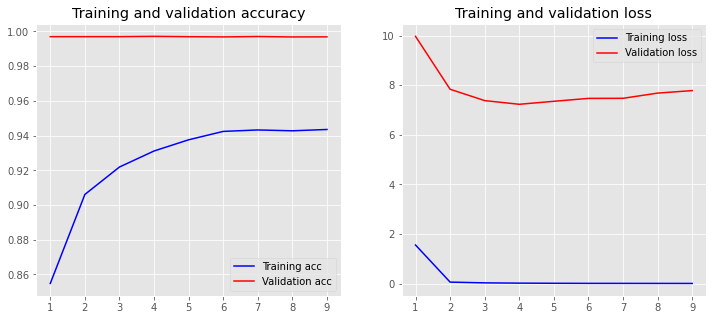

864/864 [==============================] - 68s 74ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7583940449794109,0.7630467691817385,0.7607132928233846,12551.0
test,0.7810734463276836,0.7977141588992455,0.7893061045234958,9012.0
treatment,0.7620593172915501,0.730814639905549,0.7461100153407846,9317.0
micro avg,0.7662430526213151,0.7634391191709845,0.7648385160672864,30880.0
macro avg,0.7671756028662148,0.7638585226621776,0.7653764708958883,30880.0
weighted avg,0.766118659846083,0.7634391191709845,0.7646517540518826,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10548 words (18158 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2870600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,032,856
Trainable params: 3,032,856
Non-train

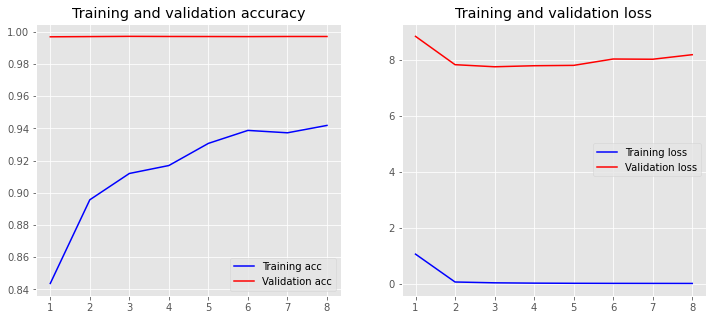

864/864 [==============================] - 69s 76ms/step
F1-score: 76.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7857505500084617,0.7398613656282368,0.7621158028642948,12551.0
test,0.8309137489325363,0.7557700843320018,0.7915625544773084,9012.0
treatment,0.7755914467697907,0.7318879467639798,0.75310619029212,9317.0
micro avg,0.7955010934842226,0.7420984455958549,0.7678724010253488,30880.0
macro avg,0.7974185819035963,0.7425064655747394,0.7689281825445744,30880.0
weighted avg,0.7958657826454132,0.7420984455958549,0.7679911773850696,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10567 words (18164 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2873100   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,035,356
Trainable params: 3,035,356
Non-train

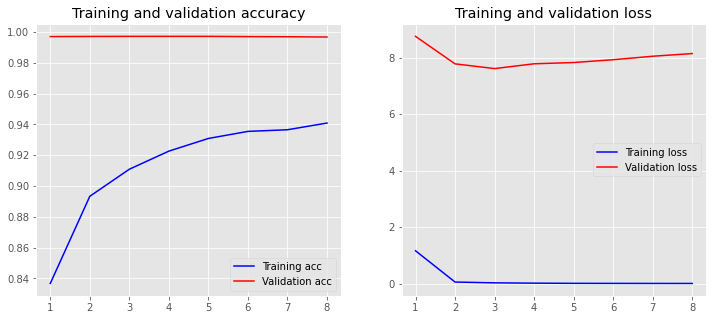

864/864 [==============================] - 74s 82ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7687912441654595,0.7611345709505218,0.7649437482483885,12551.0
test,0.7901510912143257,0.7833999112294718,0.7867610185546331,9012.0
treatment,0.7673114341307085,0.7195449178920253,0.7426609061703778,9317.0
micro avg,0.7747026380490398,0.7550841968911917,0.7647676211092526,30880.0
macro avg,0.7754179231701647,0.7546931333573398,0.7647885576577997,30880.0
weighted avg,0.7745784058076424,0.7550841968911917,0.764587789710793,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Converted 10536 words (18151 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2868700   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,030,956
Trainable params: 3,030,956
Non-train

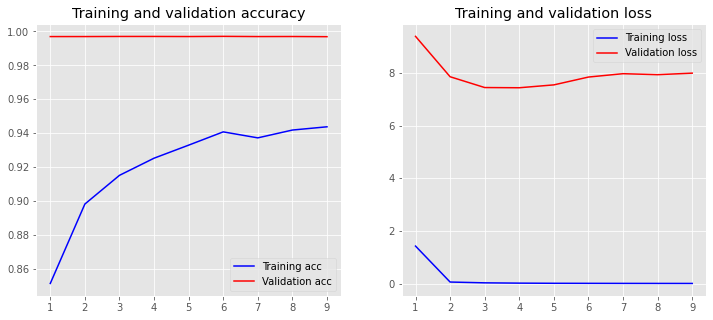

864/864 [==============================] - 73s 80ms/step
F1-score: 75.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7144539299381808,0.7734841845271293,0.7427981177550786,12551.0
test,0.8033595677199578,0.7588770528184643,0.7804850213980029,9012.0
treatment,0.7808411214953271,0.7173983041751637,0.7477764725625107,9317.0
micro avg,0.7576726134176968,0.7522992227979275,0.7549763572252646,30880.0
macro avg,0.7662182063844886,0.7499198471735857,0.757019870571864,30880.0
weighted avg,0.7604301952046091,0.7522992227979275,0.7552986911803014,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10694 words (18218 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2891200   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,053,456
Trainable params: 3,053,456
Non-trai

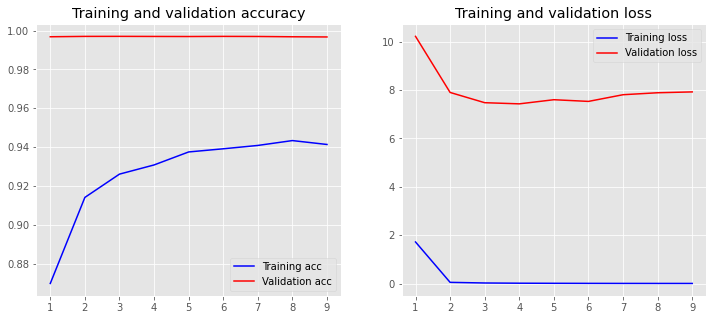

864/864 [==============================] - 71s 79ms/step
F1-score: 75.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7673648480834506,0.7385068918811251,0.752659358505887,12551.0
test,0.7584011688582759,0.8063692853972481,0.7816499946219209,9012.0
treatment,0.7796630280018985,0.7052699366748953,0.740602986756833,9317.0
micro avg,0.7679550666356476,0.7482836787564767,0.7579917663074677,30880.0
macro avg,0.7684763483145417,0.7500487046510895,0.7583041132948803,30880.0
weighted avg,0.7684594551146327,0.7482836787564767,0.7574823635930554,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10675 words (18225 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2890000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,052,256
Trainable params: 3,052,256
Non-trai

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10646 words (18202 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2884800   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,047,056
Trainable params: 3,047,056
Non-trainab

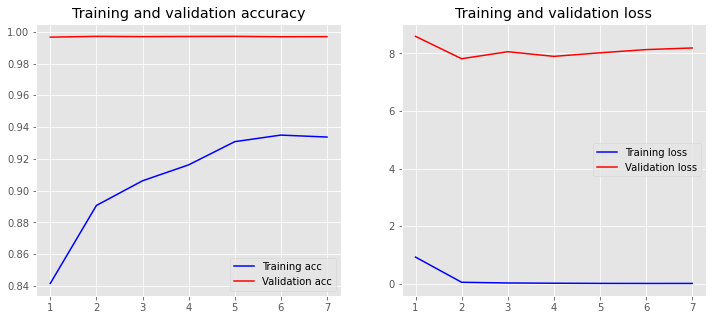

864/864 [==============================] - 63s 70ms/step
F1-score: 76.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.7569692637598284,0.7593817225719066,0.758173574099117,12551.0
test,0.7941210778024029,0.7554371948513093,0.7742962752345749,9012.0
treatment,0.7931075319753671,0.7187936030911237,0.7541242047182027,9317.0
micro avg,0.7780329640637665,0.7459844559585492,0.7616717365427854,30880.0
macro avg,0.7813992911791994,0.7445375068381134,0.7621980180172981,30880.0
weighted avg,0.7787151314125439,0.7459844559585492,0.7616570523410461,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10697 words (18215 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2891200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,053,456
Trainable params: 3,053,456
Non-train

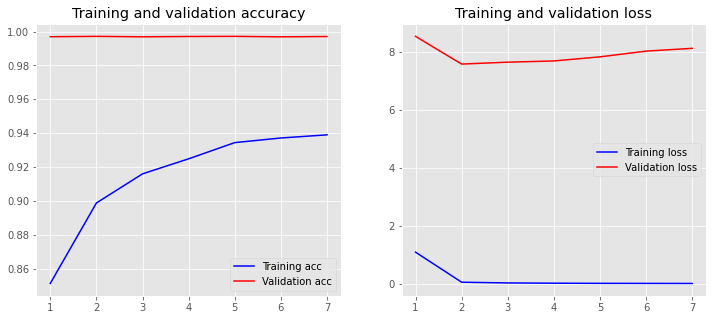

864/864 [==============================] - 64s 70ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7717890866549678,0.7358776193132022,0.7534056611469124,12551.0
test,0.7888171572382099,0.7999334221038615,0.7943364001983363,9012.0
treatment,0.8148427672955975,0.6952881828914886,0.7503330051543406,9317.0
micro avg,0.7889248348017621,0.7423251295336788,0.7649159103043246,30880.0
macro avg,0.791816337062925,0.7436997414361842,0.7660250221665299,30880.0
weighted avg,0.7897485463254641,0.7423251295336788,0.7644237921199902,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10670 words (18206 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2887600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,049,856
Trainable params: 3,049,856
Non-train

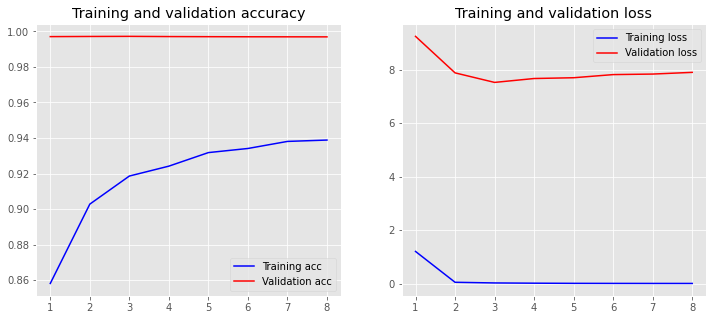

864/864 [==============================] - 62s 69ms/step
F1-score: 76.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.7566971320516861,0.7651979921918572,0.7609238204650796,12551.0
test,0.8160027790643817,0.7819573901464714,0.7986174070716229,9012.0
treatment,0.7271798016968211,0.7635504990876891,0.7449214659685863,9317.0
micro avg,0.7638777281347433,0.7695919689119171,0.7667242019002758,30880.0
macro avg,0.7666265709376296,0.7702352938086726,0.7681542311684296,30880.0
weighted avg,0.7650989948742941,0.7695919689119171,0.7670961218139895,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10691 words (18227 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2891800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,054,056
Trainable params: 3,054,056
Non-train

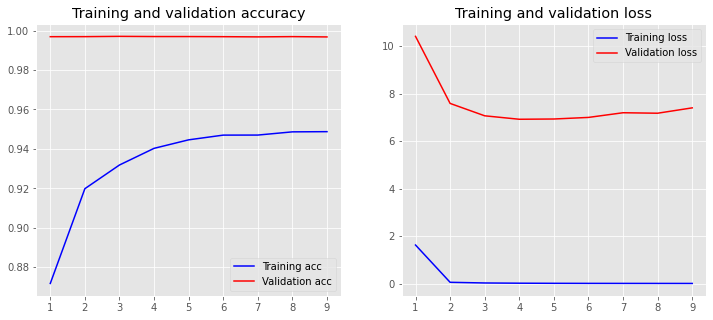

864/864 [==============================] - 64s 71ms/step
F1-score: 76.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.7737092334640087,0.7390646163652299,0.7559902200488997,12551.0
test,0.8086290883785665,0.7736351531291611,0.7907451514120449,9012.0
treatment,0.7856550088915234,0.711280455082108,0.7466200991437585,9317.0
micro avg,0.7875438958892791,0.740770725388601,0.7634415779461334,30880.0
macro avg,0.7893311102446995,0.7413267415254996,0.764451823534901,30880.0
weighted avg,0.7875044576268373,0.740770725388601,0.7633059591995298,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10706 words (18232 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2893800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,056,056
Trainable params: 3,056,056
Non-train

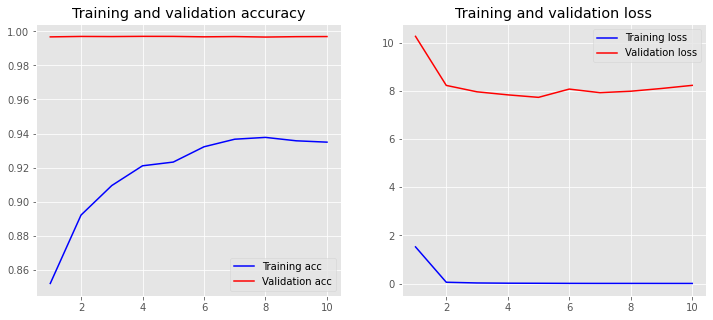

864/864 [==============================] - 63s 69ms/step
F1-score: 76.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.768429684296843,0.7466337343637958,0.7573749292815002,12551.0
test,0.7828355723326301,0.7824012427873945,0.7826183473000722,9012.0
treatment,0.7581552305961755,0.7234088225823763,0.740374581205031,9317.0
micro avg,0.7697062342150738,0.7500647668393783,0.7597585777078003,30880.0
macro avg,0.7698068290752161,0.7508145999111889,0.760122619262201,30880.0
weighted avg,0.769533919330826,0.7500647668393783,0.759612670219159,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10702 words (18212 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2891400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,053,656
Trainable params: 3,053,656
Non-train

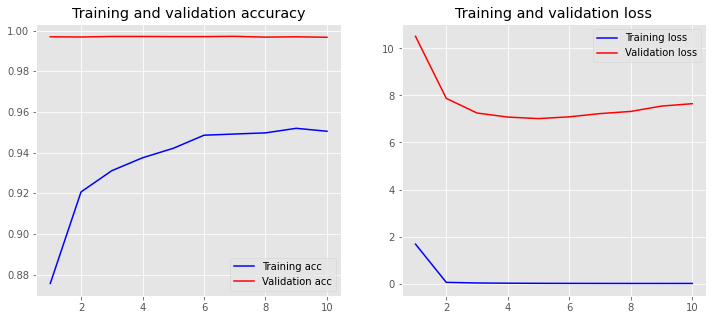

864/864 [==============================] - 64s 70ms/step
F1-score: 75.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.7523976315570011,0.7188271850848538,0.7352294026566701,12551.0
test,0.8061271676300578,0.7737461162893919,0.7896048012682595,9012.0
treatment,0.7713314580403188,0.7063432435333262,0.7374082581657236,9317.0
micro avg,0.7738662461865423,0.7310880829015544,0.7518691822223702,30880.0
macro avg,0.7766187524091258,0.7329721816358573,0.7540808206968844,30880.0
weighted avg,0.7737906704312062,0.7310880829015544,0.751755681447651,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10682 words (18226 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2890800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,053,056
Trainable params: 3,053,056
Non-train

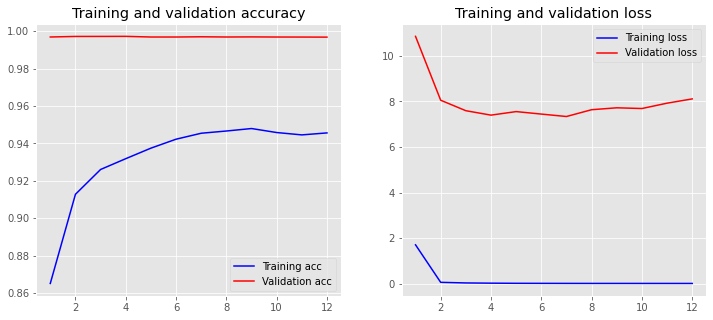

864/864 [==============================] - 65s 71ms/step
F1-score: 75.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.7381546134663342,0.7546809019201657,0.7463262813694205,12551.0
test,0.7662099471356133,0.7880603639591656,0.7769815655598709,9012.0
treatment,0.7289798501951683,0.7416550391757003,0.7352628218769952,9317.0
micro avg,0.7436352121595947,0.7604922279792746,0.751969260326609,30880.0
macro avg,0.7444481369323719,0.7614654350183439,0.7528568896020955,30880.0
weighted avg,0.7435740887781894,0.7604922279792746,0.751934674149,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10665 words (18209 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2887400   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,049,656
Trainable params: 3,049,656
Non-train

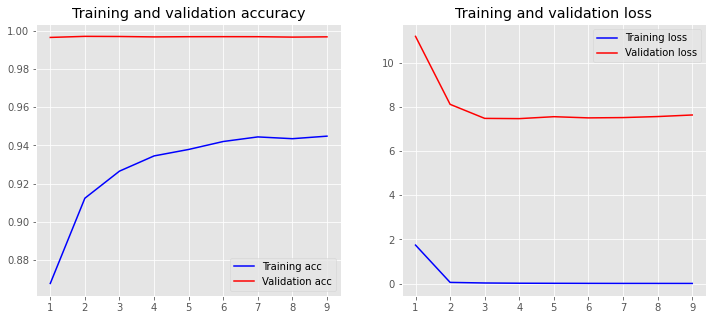

864/864 [==============================] - 64s 70ms/step
F1-score: 75.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.7613552663884114,0.7412158393753486,0.751150585385547,12551.0
test,0.790147445422334,0.7670883266755437,0.7784471595067846,9012.0
treatment,0.747089117778773,0.7162176666308898,0.7313277439859719,9317.0
micro avg,0.7655183946488294,0.7412240932642487,0.7531753866403422,30880.0
macro avg,0.7661972765298395,0.7415072775605941,0.7536418296261012,30880.0
weighted avg,0.7654536281389848,0.7412240932642487,0.7531359258214522,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Converted 10682 words (18223 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2890500   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,052,756
Trainable params: 3,052,756
Non-train

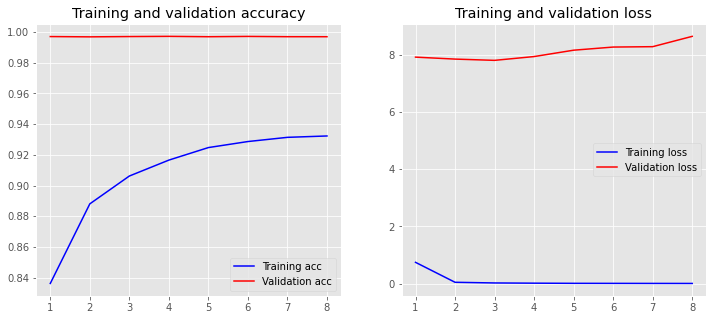

864/864 [==============================] - 65s 72ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7580368098159509,0.7383475420285236,0.7480626412657411,12551.0
test,0.8514046328240512,0.7667554371948513,0.806865950490425,9012.0
treatment,0.7799953585518682,0.7214768702372009,0.7495957624756063,9317.0
micro avg,0.7907386304775718,0.7415479274611398,0.7653536990925649,30880.0
macro avg,0.7964789337306234,0.7421932831535253,0.7681747847439242,30880.0
weighted avg,0.7919104697745499,0.7415479274611398,0.7656863301596909,30880.0



In [ ]:
number_of_training_models = 9
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10796 words (18265 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2906100   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,068,356
Trainable params: 3,068,356
Non-train

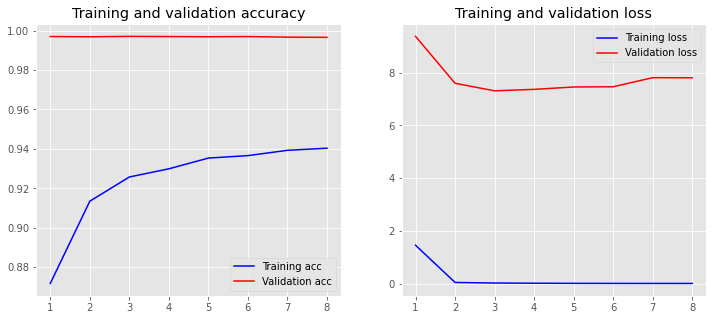

864/864 [==============================] - 65s 71ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.754973474801061,0.7256792287467134,0.7400365630712982,12551.0
test,0.7980251346499102,0.7891699955614736,0.7935728632001785,9012.0
treatment,0.7587922650684157,0.7201889020070839,0.7389867841409692,9317.0
micro avg,0.7689728025755391,0.7425518134715026,0.7555313926094335,30880.0
macro avg,0.770596958173129,0.745012708771757,0.7575320701374819,30880.0
weighted avg,0.7686898357945446,0.7425518134715026,0.755343828177114,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10772 words (18277 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2904900   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,067,156
Trainable params: 3,067,156
Non-trai

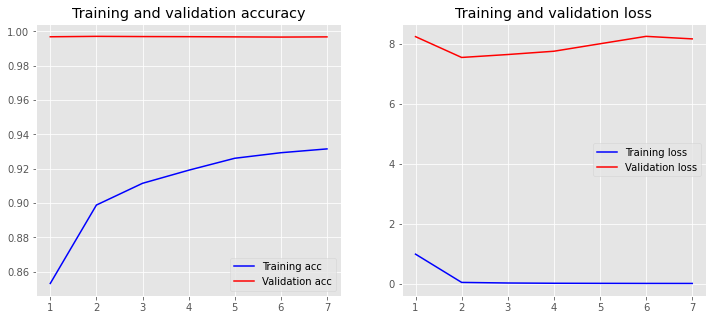

864/864 [==============================] - 64s 70ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7842277261781906,0.726555652936021,0.754290913602713,12551.0
test,0.7859387731346759,0.7492232578783844,0.76714196443788,9012.0
treatment,0.7702887019777223,0.7273800579585703,0.7482197074247862,9317.0
micro avg,0.7805079780818142,0.733419689119171,0.7562315307945305,30880.0
macro avg,0.7801517337635296,0.7343863229243253,0.756550861821793,30880.0
weighted avg,0.7805214459546181,0.733419689119171,0.7562095742946424,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10790 words (18288 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2907800   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,070,056
Trainable params: 3,070,056
Non-trai

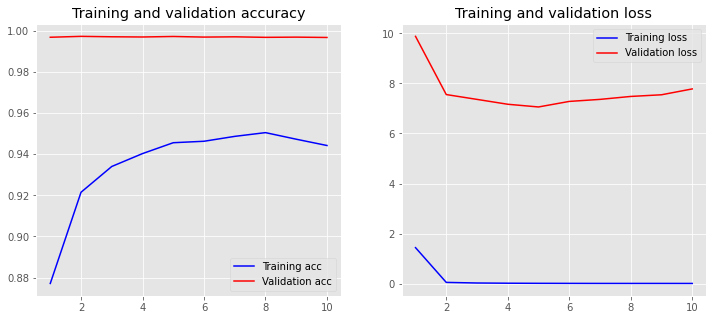

864/864 [==============================] - 64s 71ms/step
F1-score: 75.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.752241238793806,0.735399569755398,0.7437250715120262,12551.0
test,0.7916245649489165,0.7824012427873945,0.7869858809085329,9012.0
treatment,0.7442383963983278,0.7451969518085221,0.7447173656548322,9317.0
micro avg,0.7612928604209008,0.7520725388601036,0.7566546118007363,30880.0
macro avg,0.7627014000470167,0.7543325881171049,0.7584761060251304,30880.0
weighted avg,0.7613202560448159,0.7520725388601036,0.7566496705667491,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10788 words (18270 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2905800   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,068,056
Trainable params: 3,068,056
Non-trai

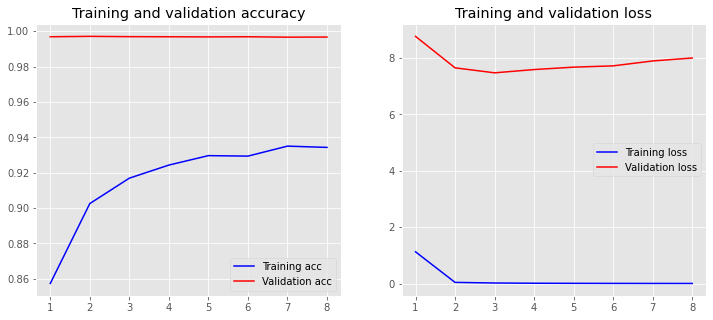

864/864 [==============================] - 65s 71ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7547355473554735,0.73332802167158,0.7438777984320699,12551.0
test,0.7773726660037565,0.7807367953839325,0.7790510989315176,9012.0
treatment,0.7964173323650448,0.7062359128474831,0.7486205131122361,9317.0
micro avg,0.7733496001084451,0.7389896373056994,0.7557792938994501,30880.0
macro avg,0.7761751819080915,0.7401002433009986,0.7571831368252745,30880.0
weighted avg,0.7739180248228472,0.7389896373056994,0.7555737070064266,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10805 words (18253 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2905800   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,068,056
Trainable params: 3,068,056
Non-trai

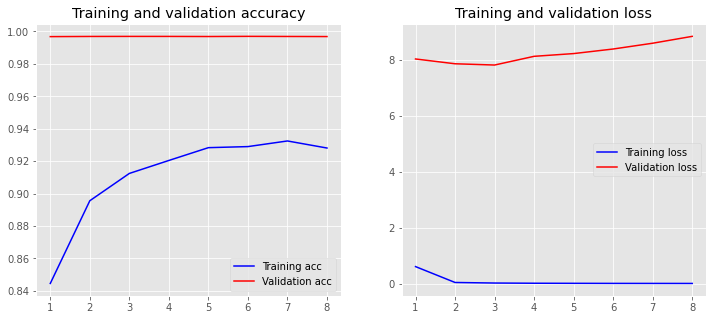

864/864 [==============================] - 64s 71ms/step
F1-score: 76.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.7393600497048773,0.758505298382599,0.7488103197388604,12551.0
test,0.8300433317284545,0.7652019529516201,0.7963048498845265,9012.0
treatment,0.78424497428705,0.7201889020070839,0.7508532423208191,9317.0
micro avg,0.7776059179556153,0.74889896373057,0.7629825140217751,30880.0
macro avg,0.7845494519067939,0.747965384447101,0.7653228039814021,30880.0
weighted avg,0.7793675166714763,0.74889896373057,0.7632874769723076,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10789 words (18257 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2904600   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,066,856
Trainable params: 3,066,856
Non-trai

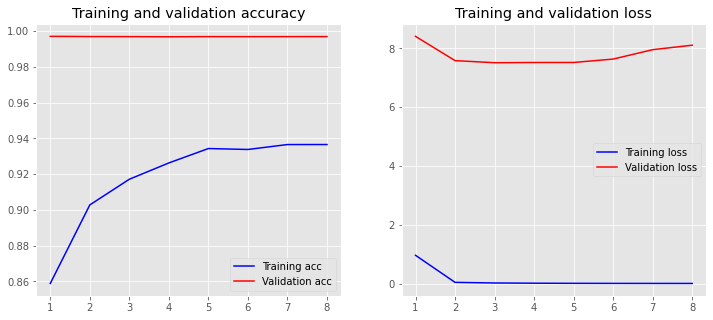

864/864 [==============================] - 65s 71ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.774879476584022,0.7171540116325392,0.7449000703438573,12551.0
test,0.758145890266975,0.8003772747447847,0.7786894094785706,9012.0
treatment,0.7733486502010339,0.7225501770956316,0.747086893796471,9317.0
micro avg,0.7690966985084632,0.7430699481865285,0.7558593428312608,30880.0
macro avg,0.7687913390173436,0.7466938211576518,0.756892124539633,30880.0
weighted avg,0.7695340818528197,0.7430699481865285,0.7554209303953481,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10797 words (18276 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2907300   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,069,556
Trainable params: 3,069,556
Non-trai

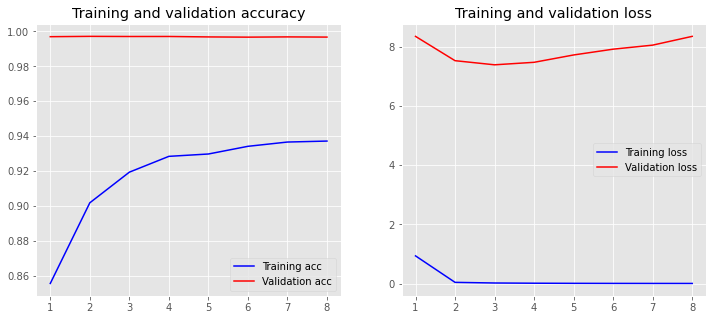

864/864 [==============================] - 67s 73ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7523571601257152,0.7438451119432714,0.748076923076923,12551.0
test,0.7769989047097481,0.7871726586773191,0.7820526954029324,9012.0
treatment,0.7747104924552579,0.7108511323387356,0.7414082615022949,9317.0
micro avg,0.7661858548258442,0.7465349740932643,0.7562327778506759,30880.0
macro avg,0.7680221857635736,0.7472896343197754,0.7571792933273834,30880.0
weighted avg,0.766292956741831,0.7465349740932643,0.7559803473097981,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10789 words (18268 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2905700   
                                                                 
 bidirectional_16 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,067,956
Trainable params: 3,067,956
Non-trai

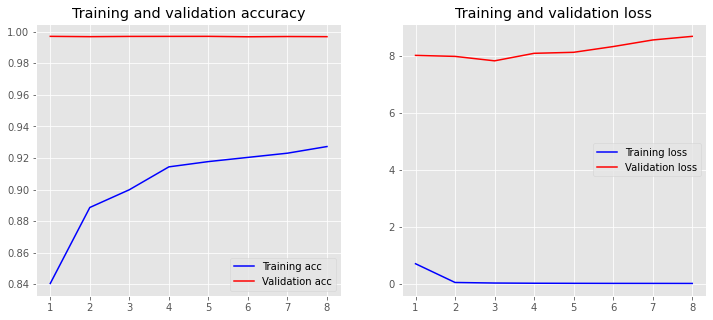

864/864 [==============================] - 65s 72ms/step
F1-score: 75.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7652246256239601,0.7328499721137758,0.7486874771071589,12551.0
test,0.8193995933500777,0.7602086107412339,0.788695101594428,9012.0
treatment,0.7870359172814125,0.6985081034667812,0.7401341976572272,9317.0
micro avg,0.7873298429319372,0.7304727979274611,0.7578363850159583,30880.0
macro avg,0.7905533787518167,0.7305222287739302,0.7591722587862714,30880.0
weighted avg,0.7876158372016886,0.7304727979274611,0.7577826133521154,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10792 words (18250 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2904200   
                                                                 
 bidirectional_17 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,066,456
Trainable params: 3,066,456
Non-trai

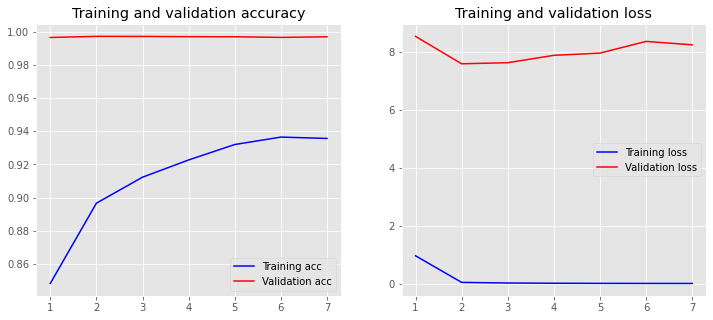

864/864 [==============================] - 67s 73ms/step
F1-score: 76.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.7759318603474448,0.7330889968926779,0.7539022491703881,12551.0
test,0.7906271072151045,0.7806258322237017,0.7855946398659968,9012.0
treatment,0.7750281214848144,0.7395084254588387,0.7568517603119678,9317.0
micro avg,0.780071510490454,0.74889896373057,0.7641674652215577,30880.0
macro avg,0.7805290296824546,0.7510744181917395,0.7654495497827841,30880.0
weighted avg,0.7799478392913638,0.74889896373057,0.7640412524169853,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Converted 10788 words (18267 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2905500   
                                                                 
 bidirectional_18 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,067,756
Trainable params: 3,067,756
Non-trai

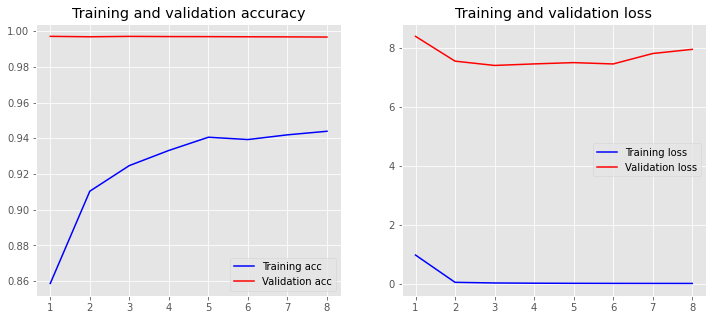

864/864 [==============================] - 67s 74ms/step
F1-score: 75.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7572537801389456,0.7381881921759222,0.747599451303155,12551.0
test,0.7713169885007594,0.788948069241012,0.7800329127811301,9012.0
treatment,0.7844548398704569,0.7019426854137598,0.7409085759601224,9317.0
micro avg,0.7692178583417254,0.7420660621761658,0.7553980550519201,30880.0
macro avg,0.7710085361700539,0.7430263156102314,0.7561803133481358,30880.0
weighted avg,0.7695649817994106,0.7420660621761658,0.7550460662406057,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10885 words (18305 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2919000   
                                                                 
 bidirectional_19 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,081,256
Trainable params: 3,081,256
Non-trai

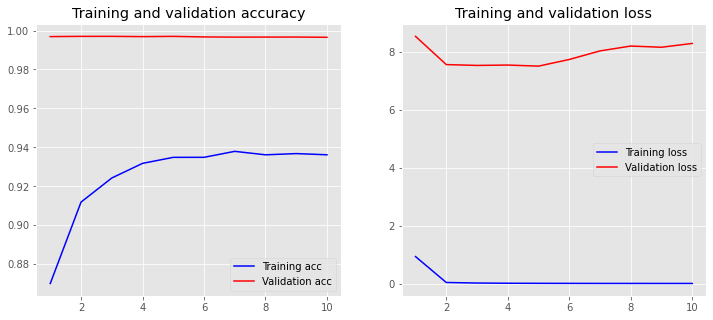

864/864 [==============================] - 64s 71ms/step
F1-score: 75.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.7501436427809243,0.7281491514620348,0.738982776744562,12551.0
test,0.7616602481814292,0.79005770084332,0.775599128540305,9012.0
treatment,0.7923181090730026,0.6907802940860792,0.7380733944954129,9317.0
micro avg,0.7653267687327173,0.7349417098445595,0.7498265437605313,30880.0
macro avg,0.768040666678452,0.7363290487971447,0.75088509992676,30880.0
weighted avg,0.7662293665604789,0.7349417098445595,0.7493944946191706,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10871 words (18294 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2916500   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,078,756
Trainable params: 3,078,756
Non-trai

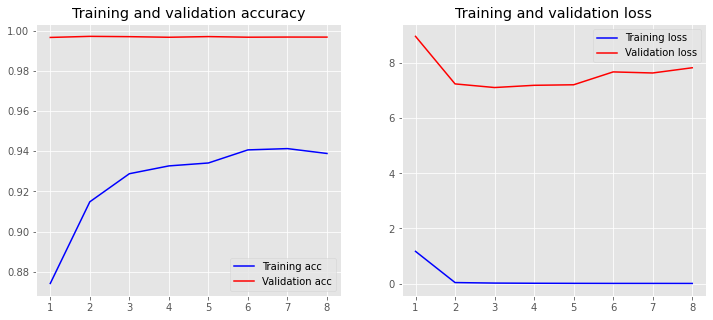

864/864 [==============================] - 64s 70ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7477111694928747,0.7483069078161103,0.7480089200382288,12551.0
test,0.776431718061674,0.7822902796271638,0.7793499889453903,9012.0
treatment,0.7739432541980312,0.7172909734893206,0.7445409982174687,9317.0
micro avg,0.763806315233188,0.7488665803108808,0.7562626725096473,30880.0
macro avg,0.7660287139175267,0.7492960536441982,0.7572999690670293,30880.0
weighted avg,0.7640076046256455,0.7488665803108808,0.7561091494872999,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10896 words (18310 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2920600   
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,082,856
Trainable params: 3,082,856
Non-trai

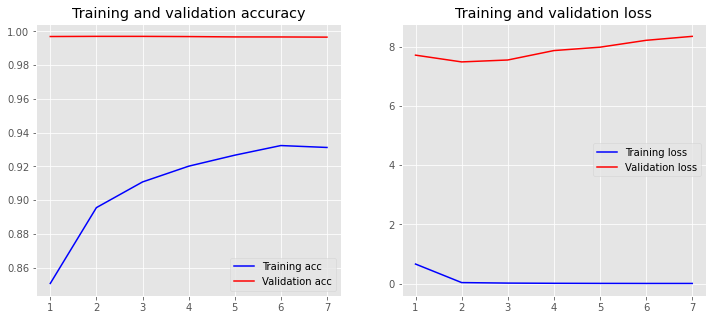

864/864 [==============================] - 64s 71ms/step
F1-score: 77.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.7900153087259738,0.7401003904071388,0.7642436957505451,12551.0
test,0.7926638335942742,0.7865068797159344,0.789573354127214,9012.0
treatment,0.8009598080383923,0.7165396586884191,0.7564015409018808,9317.0
micro avg,0.7939727914585845,0.7465349740932643,0.7695234916131185,30880.0
macro avg,0.7945463167862133,0.747715642937164,0.7700728635932133,30880.0
weighted avg,0.7940903866471825,0.7465349740932643,0.7692697813906207,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10876 words (18315 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 204, 100)          2919100   
                                                                 
 bidirectional_22 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,081,356
Trainable params: 3,081,356
Non-trai

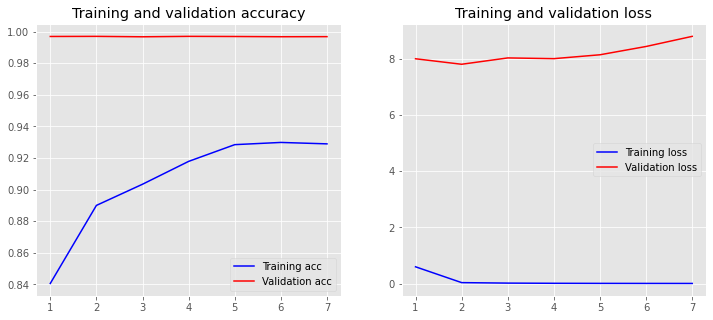

864/864 [==============================] - 63s 69ms/step
F1-score: 75.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7843637323014686,0.7106206676758824,0.7456734386756961,12551.0
test,0.8304828973843058,0.7328007101642254,0.7785899551992453,9012.0
treatment,0.759108635097493,0.7312439626489213,0.7449158101902471,9317.0
micro avg,0.7893137324192523,0.7233160621761658,0.7548751225117442,30880.0
macro avg,0.7913184215944224,0.7248884468296763,0.7563930680217296,30880.0
weighted avg,0.7902032457430842,0.7233160621761658,0.7550511855122019,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10891 words (18316 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 204, 100)          2920700   
                                                                 
 bidirectional_23 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,082,956
Trainable params: 3,082,956
Non-trai

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10900 words (18305 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2920500   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,082,756
Trainable params: 3,082,756
Non-trainab

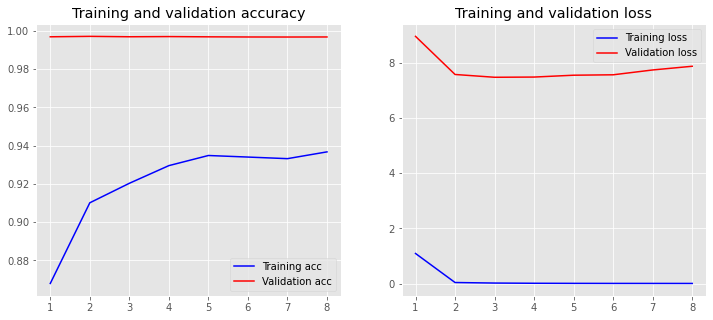

864/864 [==============================] - 66s 73ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7819660661185937,0.7123735160544976,0.7455493016468626,12551.0
test,0.8221877239073322,0.7639813581890812,0.7920165650523409,9012.0
treatment,0.778311516752732,0.6956101749490179,0.7346406710496486,9317.0
micro avg,0.7928558734672116,0.7223769430051813,0.7559772939083284,30880.0
macro avg,0.7941551022595527,0.7239883497308656,0.7574021792496173,30880.0
weighted avg,0.7926016925289039,0.7223769430051813,0.7558189670139588,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10893 words (18301 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2919400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,081,656
Trainable params: 3,081,656
Non-train

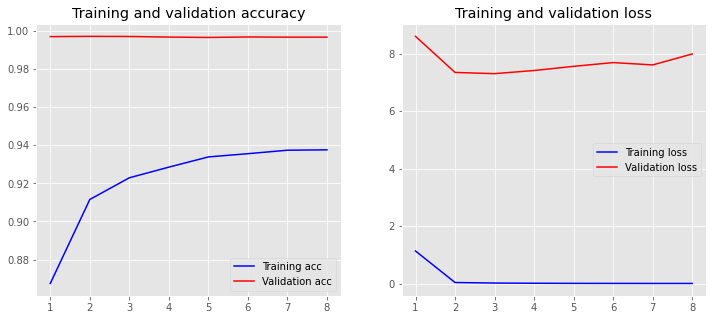

864/864 [==============================] - 68s 75ms/step
F1-score: 76.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.7687269062814914,0.7293442753565453,0.7485179279610777,12551.0
test,0.8278383886824122,0.7662006213936973,0.7958278107531839,9012.0
treatment,0.8042107917297024,0.6846624449930235,0.7396370804104586,9317.0
micro avg,0.796210212554558,0.7266191709844559,0.7598245881376882,30880.0
macro avg,0.8002586955645353,0.7267357805810888,0.7613276063749067,30880.0
weighted avg,0.7966840319329836,0.7266191709844559,0.7596453180871575,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10884 words (18301 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2918500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,080,756
Trainable params: 3,080,756
Non-train

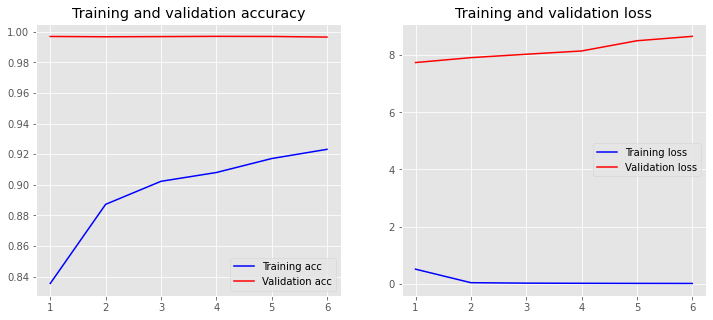

864/864 [==============================] - 69s 76ms/step
F1-score: 76.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.8107202680067002,0.694127957931639,0.7479074558956088,12551.0
test,0.8609819121447029,0.7394584997780737,0.7956064947468958,9012.0
treatment,0.8204968168767944,0.7054845980465815,0.7586565096952909,9317.0
micro avg,0.828357927312526,0.7107836787564766,0.765080084354358,30880.0
macro avg,0.8307329990093991,0.713023685252098,0.7673901534459319,30880.0
weighted avg,0.8283383393407141,0.7107836787564766,0.7650710787058237,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10880 words (18301 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2918100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,080,356
Trainable params: 3,080,356
Non-train

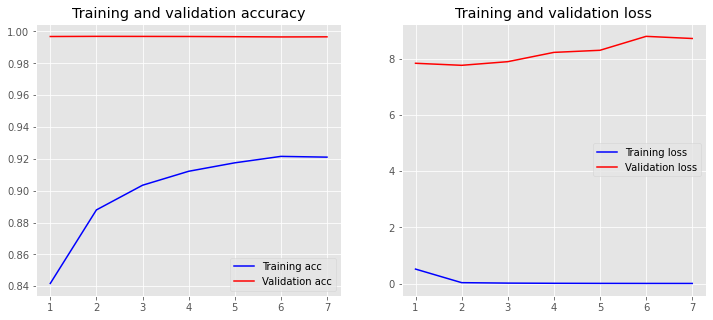

864/864 [==============================] - 67s 74ms/step
F1-score: 76.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.7815205279849147,0.7264759780097203,0.7529936410934016,12551.0
test,0.8153953326367119,0.7792942743009321,0.7969361702127661,9012.0
treatment,0.7532626882320134,0.7248041214983364,0.7387594355103381,9317.0
micro avg,0.7828346725936057,0.7413860103626942,0.7615467775467774,30880.0
macro avg,0.78339284961788,0.743524791269663,0.7628964156055019,30880.0
weighted avg,0.7828806784559061,0.7413860103626942,0.7615231093254712,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10915 words (18301 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2921600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,083,856
Trainable params: 3,083,856
Non-train

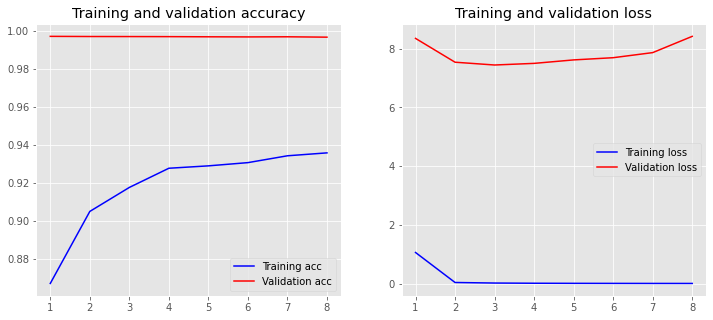

864/864 [==============================] - 67s 74ms/step
F1-score: 76.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7660485021398002,0.727352402199028,0.7461991172143209,12551.0
test,0.8104871526566678,0.7735241899689304,0.7915744052688356,9012.0
treatment,0.7713349157906635,0.7324246001931952,0.7513763488218453,9317.0
micro avg,0.7806572450195811,0.7423575129533678,0.7610258112706447,30880.0
macro avg,0.7826235235290439,0.7444337307870512,0.7630499571016672,30880.0
weighted avg,0.7806124475557039,0.7423575129533678,0.7610034683423841,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Converted 10870 words (18304 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2917400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,079,656
Trainable params: 3,079,656
Non-train

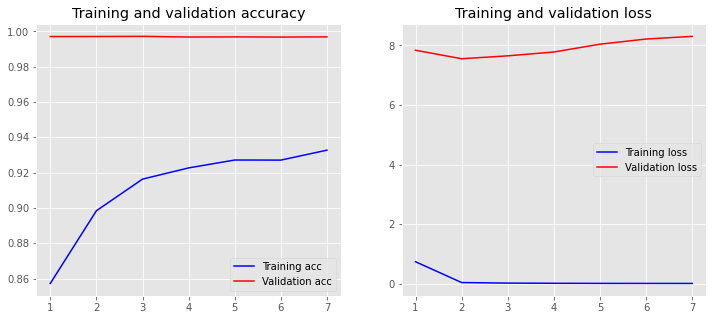

864/864 [==============================] - 67s 74ms/step
F1-score: 75.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.782997370727432,0.7118157915703928,0.7457117816451735,12551.0
test,0.7993948223691584,0.7915002219263204,0.7954279342068581,9012.0
treatment,0.7752168230961151,0.7003327251261136,0.7358745911807828,9317.0
micro avg,0.7858086956521739,0.7316062176165803,0.7577393929230253,30880.0
macro avg,0.7858696720642352,0.7345495795409422,0.7590047690109382,30880.0
weighted avg,0.7854352746106658,0.7316062176165803,0.7572528717788903,30880.0



In [ ]:
number_of_training_models = 6
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11189 words (18412 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2960100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,122,356
Trainable params: 3,122,356
Non-train

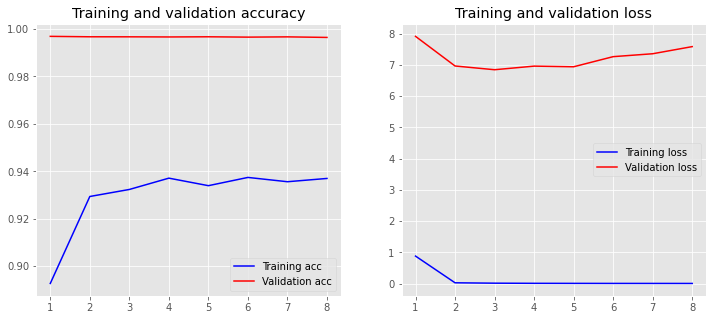

864/864 [==============================] - 66s 73ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.7594969420277371,0.7024938251932117,0.7298841059602649,12551.0
test,0.783404797774945,0.7501109631602308,0.7663964627855565,9012.0
treatment,0.7646712924850053,0.6978641193517227,0.7297418630751964,9317.0
micro avg,0.768205699175394,0.7149935233160621,0.7406450747219938,30880.0
macro avg,0.7691910107625625,0.7168229692350551,0.7420074772736726,30880.0
weighted avg,0.7680353817688059,0.7149935233160621,0.7404969324741685,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11182 words (18434 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2961600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,123,856
Trainable params: 3,123,856
Non-train

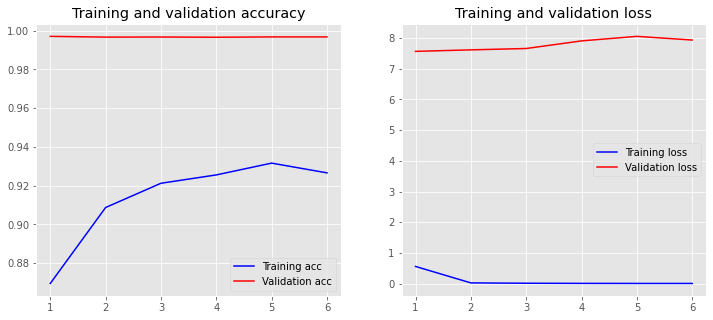

864/864 [==============================] - 69s 76ms/step
F1-score: 75.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.7818706501442879,0.7339654210819855,0.7571610570007807,12551.0
test,0.7762562120375484,0.7799600532623169,0.7781037250235235,9012.0
treatment,0.7935580151722422,0.6848771063647097,0.73522295195299,9317.0
micro avg,0.7833644989265185,0.7325777202072539,0.7571203855550721,30880.0
macro avg,0.7838949591180261,0.7329341935696707,0.7568292446590981,30880.0
weighted avg,0.783758404799324,0.7325777202072539,0.7566538678651166,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11175 words (18440 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2961500   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,123,756
Trainable params: 3,123,756
Non-train

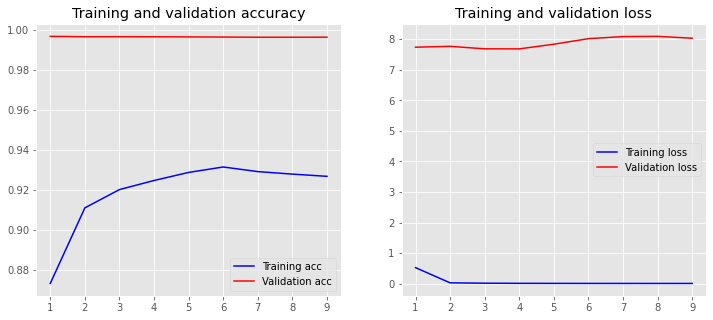

864/864 [==============================] - 65s 72ms/step
F1-score: 73.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.7509942936192288,0.6920564098478209,0.7203217647302732,12551.0
test,0.7846851956891662,0.7675321793164669,0.7760139114825827,9012.0
treatment,0.7694180667153641,0.6783299345282816,0.7210084992299356,9317.0
micro avg,0.7666724951914671,0.7099417098445596,0.7372173182009247,30880.0
macro avg,0.7683658520079196,0.7126395078975231,0.7391147251475972,30880.0
weighted avg,0.7663853785735995,0.7099417098445596,0.7367821252181348,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11138 words (18439 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2957700   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,119,956
Trainable params: 3,119,956
Non-train

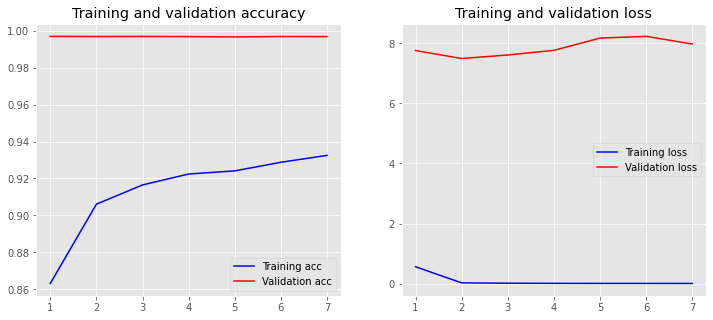

864/864 [==============================] - 68s 75ms/step
F1-score: 74.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7546784620619258,0.7068759461397498,0.729995474554655,12551.0
test,0.7717283268912203,0.775410563692854,0.7735650633752144,9012.0
treatment,0.7657398897058824,0.7153590211441451,0.7396925808778647,9317.0
micro avg,0.7631712688463493,0.7294365284974094,0.7459226757181887,30880.0
macro avg,0.7640488928863428,0.732548510325583,0.747751039602578,30880.0
weighted avg,0.7629916972691908,0.7294365284974094,0.7456365715126934,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11179 words (18473 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2965200   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,127,456
Trainable params: 3,127,456
Non-trai

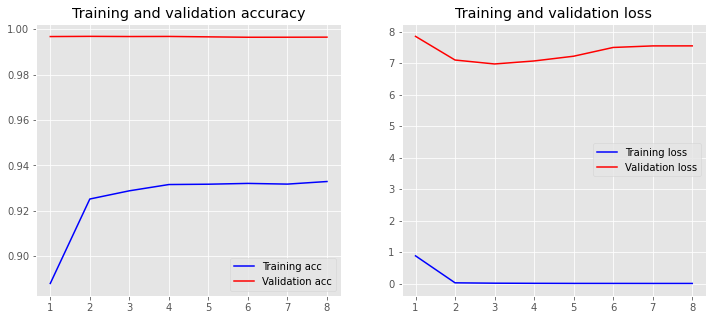

864/864 [==============================] - 67s 74ms/step
F1-score: 74.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7680515634526609,0.7025735001195124,0.733854860186418,12551.0
test,0.7662421756960932,0.787838437638704,0.7768902505744611,9012.0
treatment,0.7632657842333372,0.6993667489535258,0.7299204660020163,9317.0
micro avg,0.7660838683239994,0.7264896373056995,0.7457615850009972,30880.0
macro avg,0.765853174460697,0.729926228903914,0.7468885255876319,30880.0
weighted avg,0.7660795651544542,0.7264896373056995,0.7452272108198693,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11174 words (18437 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2961100   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,123,356
Trainable params: 3,123,356
Non-trai

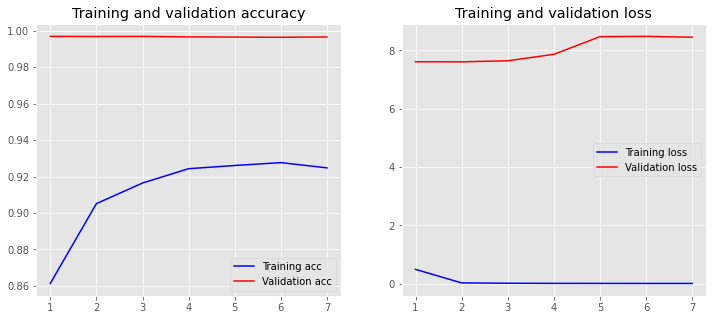

864/864 [==============================] - 67s 74ms/step
F1-score: 75.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7805049088359046,0.709425543781372,0.7432697524938436,12551.0
test,0.8251234493556546,0.7602086107412339,0.7913369910482241,9012.0
treatment,0.8003037205770691,0.678759257271654,0.7345374295835995,9317.0
micro avg,0.7995871509796111,0.7149935233160621,0.7549279400953961,30880.0
macro avg,0.8019773595895429,0.7161311372647533,0.756381391041889,30880.0
weighted avg,0.7994999806026281,0.7149935233160621,0.7546629811627987,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11127 words (18436 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2956300   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,118,556
Trainable params: 3,118,556
Non-trai

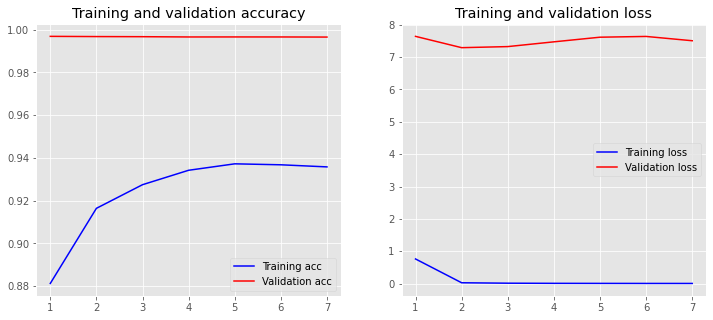

864/864 [==============================] - 66s 73ms/step
F1-score: 75.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.779869659666908,0.6864791650067724,0.7302004322217044,12551.0
test,0.8091437692395393,0.7875055481580115,0.7981780352021595,9012.0
treatment,0.7780230561687516,0.6809058709885156,0.7262320416690516,9317.0
micro avg,0.788510349265363,0.7142810880829016,0.7495624692029295,30880.0
macro avg,0.7890121616917329,0.7182968613844332,0.7515368363643051,30880.0
weighted avg,0.7878558471888067,0.7142810880829016,0.7488416454108494,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11200 words (18477 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2967700   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,129,956
Trainable params: 3,129,956
Non-trai

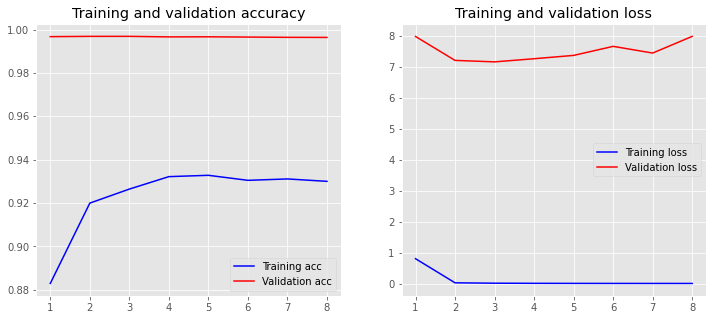

864/864 [==============================] - 67s 74ms/step
F1-score: 74.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.7486544211875267,0.6981913791729742,0.7225428759894459,12551.0
test,0.8287613293051359,0.7609853528628495,0.7934285879562676,9012.0
treatment,0.8287037037037037,0.6532145540410004,0.7305683932537063,9317.0
micro avg,0.7944298052993705,0.7029468911917098,0.745893753006666,30880.0
macro avg,0.8020398180654554,0.7041304286922747,0.7488466190664732,30880.0
weighted avg,0.7961849464841302,0.7029468911917098,0.7456515476408744,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11160 words (18450 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2961000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,123,256
Trainable params: 3,123,256
Non-trai

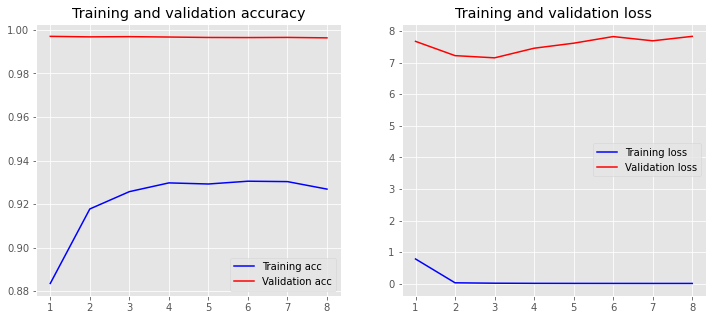

864/864 [==============================] - 71s 79ms/step
F1-score: 74.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7618598267135627,0.7075930204764561,0.7337243886318572,12551.0
test,0.7958950969213227,0.7745228584110075,0.7850635474074908,9012.0
treatment,0.770135424091233,0.6958248363207041,0.7310967014378348,9317.0
micro avg,0.7746229849193967,0.7235751295336788,0.7482293846797824,30880.0
macro avg,0.7759634492420394,0.7259802384027226,0.7499615458257276,30880.0
weighted avg,0.7742895416060527,0.7235751295336788,0.7479143606946584,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11179 words (18415 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2959400   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,121,656
Trainable params: 3,121,656
Non-trai

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Converted 11127 words (18437 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2956400   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,118,656
Trainable params: 3,118,656
Non-trainab

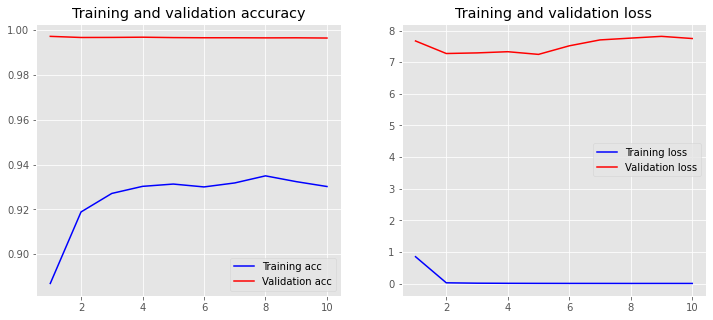

864/864 [==============================] - 63s 69ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.710820895522388,0.6981913791729742,0.7044495357530448,12551.0
test,0.8070837390457644,0.7357967154904572,0.7697933596470862,9012.0
treatment,0.7028613352898019,0.7197595792637115,0.7112100965107646,9317.0
micro avg,0.7345853415323251,0.7156735751295337,0.7250061510702862,30880.0
macro avg,0.7402553232859846,0.7179158913090476,0.7284843306369652,30880.0
weighted avg,0.7365126546916128,0.7156735751295337,0.7255592082113601,30880.0



In [ ]:
number_of_training_models = 1
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11649 words (18728 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          3037700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,199,956
Trainable params: 3,199,956
Non-train

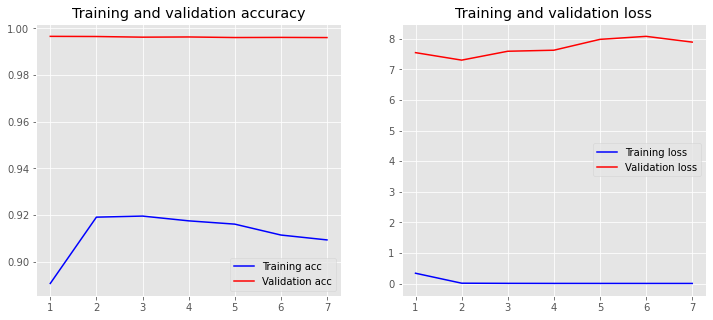

864/864 [==============================] - 64s 70ms/step
F1-score: 73.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.7436512164801989,0.6672775077683053,0.703397303993617,12551.0
test,0.8038810425996096,0.7768530847758545,0.7901359968399074,9012.0
treatment,0.790028638375423,0.6513899323816679,0.7140420024707335,9317.0
micro avg,0.7755035620005063,0.6944624352331606,0.7327490475458288,30880.0
macro avg,0.7791869658184106,0.6985068416419425,0.7358584344347526,30880.0
weighted avg,0.775221476609277,0.6944624352331606,0.731922749448347,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11737 words (18703 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          3044000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,206,256
Trainable params: 3,206,256
Non-train

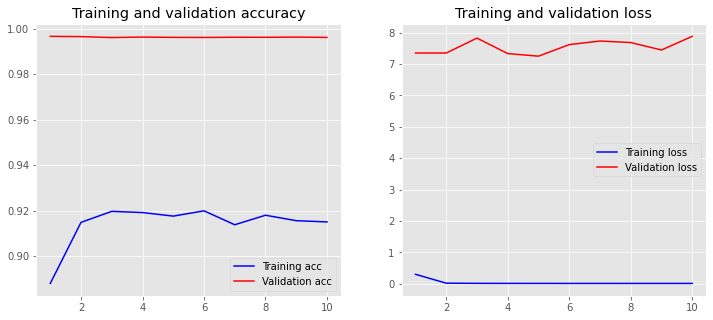

864/864 [==============================] - 63s 69ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7056236786469344,0.6648075850529839,0.6846078109616016,12551.0
test,0.77255299954894,0.7602086107412339,0.766331096196868,9012.0
treatment,0.7225447508466376,0.641193517226575,0.679442706852431,9317.0
micro avg,0.7309485169710991,0.6855246113989637,0.7075082301432127,30880.0
macro avg,0.7335738096808374,0.688736571006931,0.7101272046703002,30880.0
weighted avg,0.7302616537004806,0.6855246113989637,0.7068994875015977,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11749 words (18711 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          3046000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,208,256
Trainable params: 3,208,256
Non-train

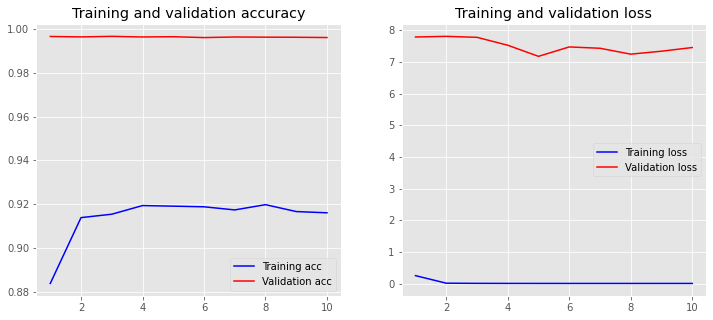

864/864 [==============================] - 65s 72ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.7443395361628014,0.6469604015616286,0.6922421142369991,12551.0
test,0.7486893840104849,0.7606524633821571,0.7546235138705416,9012.0
treatment,0.7424924012158055,0.655468498443705,0.69627180481131,9317.0
micro avg,0.745210321668434,0.6827072538860104,0.7125908399526787,30880.0
macro avg,0.7451737737963638,0.6876937877958302,0.7143791443062836,30880.0
weighted avg,0.7450516822930529,0.6827072538860104,0.7116632865355205,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11659 words (18691 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          3035000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,197,256
Trainable params: 3,197,256
Non-train

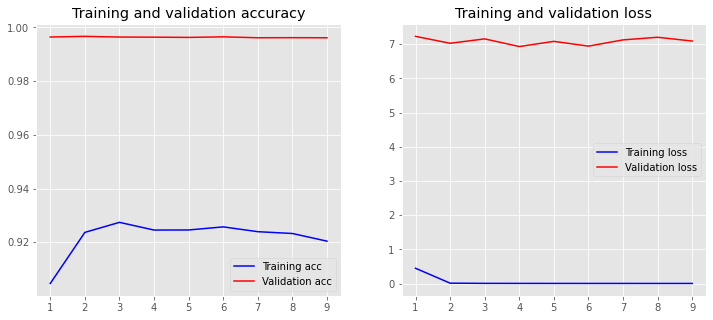

864/864 [==============================] - 65s 72ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.7236795774647887,0.6550075691179985,0.6876333068462214,12551.0
test,0.813633067440174,0.7470039946737683,0.7788962165914614,9012.0
treatment,0.7309900410076157,0.6696361489749919,0.6989693031593098,9317.0
micro avg,0.752316376158188,0.6862694300518135,0.7177767616725093,30880.0
macro avg,0.7561008953041929,0.6905492375889196,0.7218329421989975,30880.0
weighted avg,0.7521372342163007,0.6862694300518135,0.7176876727877093,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11723 words (18689 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          3041200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,203,456
Trainable params: 3,203,456
Non-train

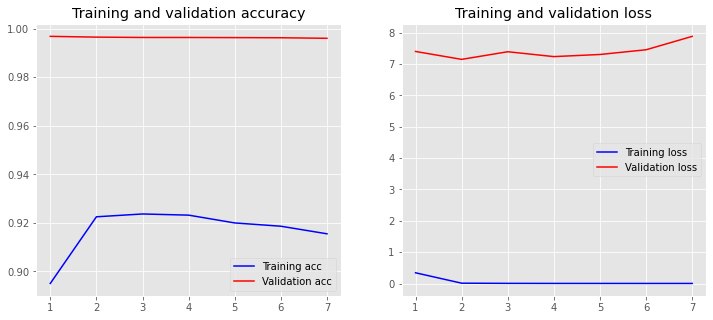

864/864 [==============================] - 65s 71ms/step
F1-score: 72.7%


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11715 words (18685 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          3040000   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,202,256
Trainable params: 3,202,256
Non-trainab

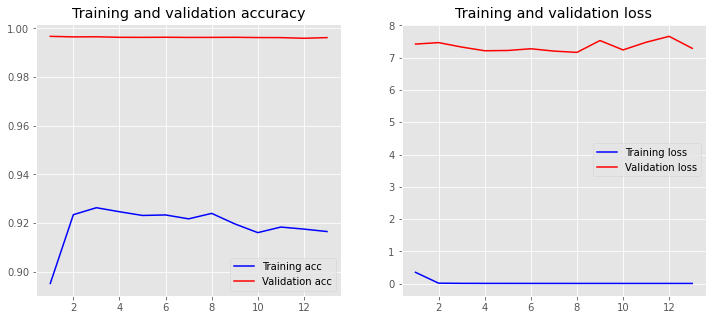

864/864 [==============================] - 63s 70ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.715946401632798,0.6428173053939925,0.6774139378673384,12551.0
test,0.7625890875102231,0.7242565468264536,0.7429286893176257,9012.0
treatment,0.7433018627200817,0.6253085757217989,0.6792188866219762,9317.0
micro avg,0.7381262199089135,0.6613018134715026,0.6976053018139583,30880.0
macro avg,0.7406124506210343,0.6641274759807484,0.6998538379356468,30880.0
weighted avg,0.7378121631638076,0.6613018134715026,0.6970783046943121,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11718 words (18673 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          3039100   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,201,356
Trainable params: 3,201,356
Non-train

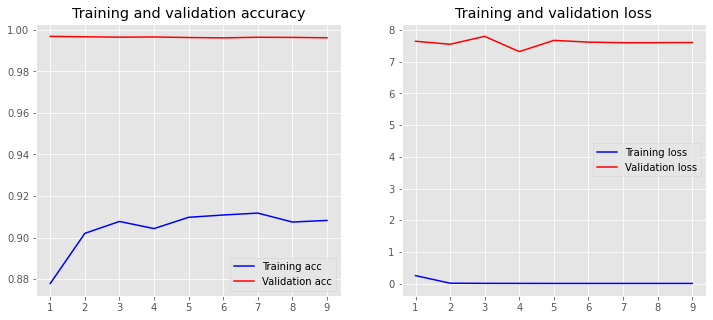

864/864 [==============================] - 63s 69ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.7094212981910453,0.6905425862481077,0.6998546511627907,12551.0
test,0.7839628123184196,0.7485574789169995,0.765851166486916,9012.0
treatment,0.7263858602088833,0.6792959107008694,0.7020521353300055,9317.0
micro avg,0.7361435584899272,0.704080310880829,0.7197550277249026,30880.0
macro avg,0.7399233235727828,0.7061319919553256,0.7225859843265706,30880.0
weighted avg,0.7362939325704525,0.704080310880829,0.7197780499998035,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11743 words (18695 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          3043800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,206,056
Trainable params: 3,206,056
Non-train

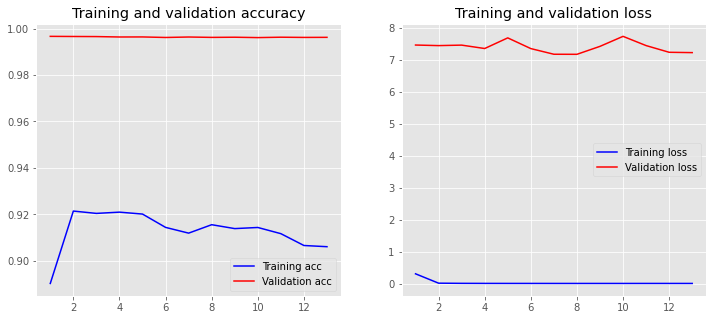

864/864 [==============================] - 65s 72ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.6848658198031463,0.6486335750139431,0.6662574678778951,12551.0
test,0.7553438919038653,0.756768752774079,0.7560556510171276,9012.0
treatment,0.7437305053025577,0.639798218310615,0.6878606046618971,9317.0
micro avg,0.7231689191524662,0.6775259067357513,0.6996037518182274,30880.0
macro avg,0.7279800723365231,0.6817335153662123,0.7033912411856399,30880.0
weighted avg,0.7231945329044965,0.6775259067357513,0.6989821327699713,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11698 words (18701 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          3039900   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,202,156
Trainable params: 3,202,156
Non-train

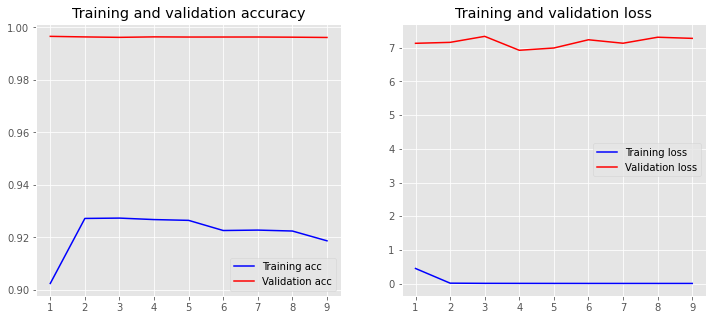

864/864 [==============================] - 66s 73ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.7175689479060265,0.6716596287148434,0.6938557142269229,12551.0
test,0.7983183036802339,0.7269196626719929,0.7609478452781973,9012.0
treatment,0.7696519358623387,0.6336803692175593,0.6950788792088534,9317.0
micro avg,0.7560180995475113,0.6763277202072538,0.7139560721305871,30880.0
macro avg,0.7618463958161997,0.6774198868681318,0.7166274795713244,30880.0
weighted avg,0.7568490772138671,0.6763277202072538,0.7138048888762342,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11675 words (18703 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          3037800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,200,056
Trainable params: 3,200,056
Non-train

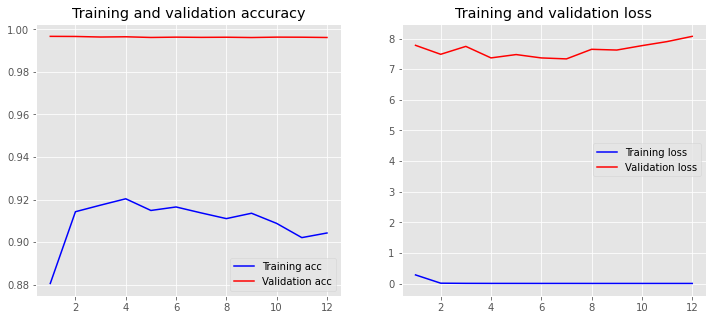

864/864 [==============================] - 65s 72ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.7106198526224534,0.6530953708867819,0.6806443577181766,12551.0
test,0.752803845273518,0.7299156679982246,0.7411830985915493,9012.0
treatment,0.7165718349928877,0.648813995921434,0.6810116600011266,9317.0
micro avg,0.7252081228882928,0.6742227979274611,0.698786688818406,30880.0
macro avg,0.7266651776296197,0.6772750116021468,0.7009463721036174,30880.0
weighted avg,0.7247266130342646,0.6742227979274611,0.6984227673075898,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
number_of_training_models = 6
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Converted 11723 words (18721 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          3044400   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,206,656
Trainable params: 3,206,656
Non-trainab

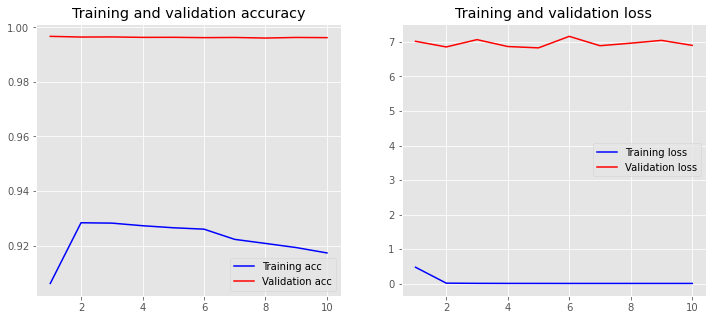

864/864 [==============================] - 66s 73ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.717391304347826,0.6336546888694128,0.6729280365528622,12551.0
test,0.788203115709359,0.7354638260097648,0.7609207278571838,9012.0
treatment,0.7557223264540338,0.6484920038639047,0.6980129390018485,9317.0
micro avg,0.7502000727537286,0.6678432642487047,0.70663011821141,30880.0
macro avg,0.753772248837073,0.6725368395810274,0.7106205678039648,30880.0
weighted avg,0.7496220743268958,0.6678432642487047,0.7061762933582946,30880.0



In [13]:
number_of_training_models = 1
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)